In [1]:
import logging
import re
from typing import Literal, Annotated

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from tqdm import tqdm
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.DEBUG)
logger = logging.getLogger('base')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = 650
pd.options.display.max_rows = 20

# Load data

In [10]:
files = list(Path('../data/results/').glob('simulation-*.csv'))
for fp in files:
    print(fp)
df = pd.concat([
    pd.read_csv(fp)
    for fp in files
])
# df = pd.read_csv('../data/results/results.csv')
print(df.shape)
print(list(df.columns))
df.head()

../data/results/simulation-APRIORI.csv
../data/results/simulation-BUSCAR.csv
../data/results/simulation-CurveFitting.csv
../data/results/simulation-METHOD2399.csv
../data/results/simulation-BATCHPRECISION.csv
../data/results/simulation-HEURISTIC_SCORES.csv
../data/results/simulation-ALISON.csv
../data/results/simulation-HEURISTIC_FIX.csv
../data/results/simulation-KNEE.csv
../data/results/simulation-QUANT.csv
../data/results/simulation-HEURISTIC_FRAC.csv
(2136903, 46)
['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-recall_target', 'method-inclusion_threshold', 'method-est_recall', 'method-bias', 'method-confidence_level', 'method-expected_includes', 'method-expected_remaining', 'method-predicted_recall', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed', 'met

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-expected_includes,method-expected_remaining,method-predicted_recall,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-target_recall,method-nstd,method-est_var,method-fraction
0,clef-CD009175,2,clef-CD009175-0-500-2-best,0,4862,15,4847,61,0,0,15,APRIORI,False,APRIORI-f2879eb555b2b71aee4681ff5073424d4fd03b5a,APRIORI,False,NaN,0.80,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,clef-CD009175,2,clef-CD009175-0-500-2-best,0,4862,15,4847,61,0,0,15,APRIORI,False,APRIORI-6820479463a81f5ec984ee2a6db0def447fa8f5a,APRIORI,False,NaN,0.90,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clef-CD009175,2,clef-CD009175-0-500-2-best,0,4862,15,4847,61,0,0,15,APRIORI,False,APRIORI-6698d1534b63eccb1e6945b6ed9551e36124b222,APRIORI,False,NaN,0.95,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,clef-CD009175,2,clef-CD009175-0-500-2-best,0,4862,15,4847,61,0,0,15,APRIORI,False,APRIORI-ef7582f2d6287119bcac527072f319480a44f13c,APRIORI,False,NaN,0.99,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,clef-CD009175,2,clef-CD009175-0-500-2-best,1,4862,30,4832,61,0,0,15,APRIORI,False,APRIORI-f2879eb555b2b71aee4681ff5073424d4fd03b5a,APRIORI,False,NaN,0.80,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

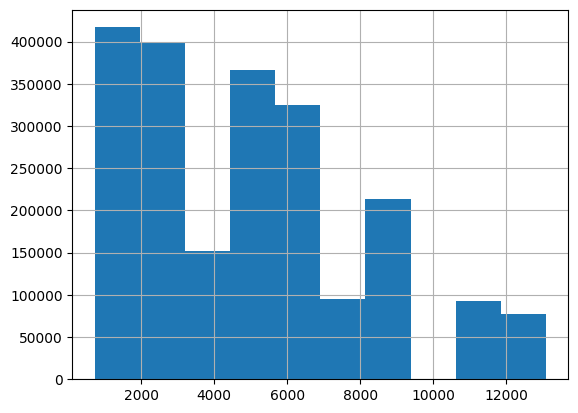

In [4]:
df['n_total'].hist()

In [5]:
results = []
RECALL_TARGETS = [0.8, 0.85, 0.9, 0.95, 0.99, 1.0]
for (hash_ranker, hash_method, repeat), sub_df in tqdm(df.groupby(['sim_key', 'method-hash', 'sim-rep'])):
    simulation = sub_df.sort_values(by=['batch_i'])
    simulation = simulation.where(simulation['dataset'].notna())
    rel_curve = simulation['n_incl_seen'] / simulation['n_incl']
    
    #info = simulation.iloc[0]
    #logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    stop_rows = simulation[simulation['safe_to_stop']]
    stop_row = (stop_rows.iloc[0] if  len(stop_rows) > 0 else simulation.iloc[-1]).to_dict()

    for t in RECALL_TARGETS:
        step = np.argwhere(rel_curve >= t).min()
        stop_row[f'seen@recall={t}'] = simulation.iloc[step]['n_seen']
        stop_row[f'unseen@recall={t}'] = simulation.iloc[step]['n_unseen']
        stop_row[f'seen_incl@recall={t}'] = simulation.iloc[step]['n_incl_seen']
        
        stop_row[f'too_late@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen'])
        stop_row[f'too_late_left%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (simulation.iloc[step]['n_seen'])
        stop_row[f'too_late_right%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (stop_row['n_total'] - simulation.iloc[step]['n_seen'])
        
        stop_row[f'too_early@recall={t}'] = max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen'])
        stop_row[f'too_early%@recall={t}'] = -max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen']) / (simulation.iloc[step]['n_seen'])

        stop_row[f'missed@recall={t}'] =  max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen'])
        stop_row[f'missed%@recall={t}'] =  -max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen']) / stop_row['n_incl']

    results.append(stop_row)

df_res = pd.DataFrame(results)
df_res['stop_recall'] = df_res['n_incl_seen'] / df_res['n_incl']
df_res['work_saved'] = df_res['n_unseen'] / df_res['n_total']
df_res['incl_missed'] = (df_res['n_incl'] - df_res['n_incl_seen']) / df_res['n_incl']

for t in RECALL_TARGETS:
    df_res[f'tetl_left@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'tetl_right@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'mtl_right@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'mtl_left@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'missed_%@recall={t}'] = df_res[f'missed%@recall={t}'] * -100

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10261/10261 [01:40<00:00, 102.33it/s]


# Basic tests

In [3]:
for (hash_ranker, hash_method, repeat), sub_df in df.groupby(['sim_key', 'method-hash', 'sim-rep']):
    simulation = sub_df.sort_values(by=['batch_i'])
    info = simulation.iloc[0]
    logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    for _, step in simulation.iterrows():
        recall = step['n_incl_seen'] / step['n_incl']

        logger.info(f'Batch {step['batch_i']}: {step['n_seen']:,}/{step['n_total']:,} seen; '
              f'{step['n_incl_seen']:,}/{step['n_incl']:,} includes found; '
              f'recall={recall:.2%} | safe to stop: {step['safe_to_stop']}')

    logger.info('---')
    break

2025-06-16 22:36:20,720 [INFO] base: Dataset "clef-CD005139" stopped by "APRIORI" (repeat 1 via APRIORI-6698d1534b63eccb1e6945b6ed9551e36124b222 / clef-CD005139-0-500-1-best)
2025-06-16 22:36:20,721 [INFO] base: Batch 0: 15/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,722 [INFO] base: Batch 1: 30/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,722 [INFO] base: Batch 2: 45/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,723 [INFO] base: Batch 3: 60/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,724 [INFO] base: Batch 4: 75/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,725 [INFO] base: Batch 5: 90/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-16 22:36:20,726 [INFO] base: Batch 6: 105/4,564 seen; 1/105 includes found; recall=0.95% | safe to stop: Fals

In [6]:
print(list(df_res.columns))
df_res.head()

['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-recall_target', 'method-inclusion_threshold', 'method-est_recall', 'method-bias', 'method-confidence_level', 'method-expected_includes', 'method-expected_remaining', 'method-predicted_recall', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed', 'method-threshold', 'method-batch_size', 'method-current_precision', 'method-est_incl', 'method-n_windows', 'method-curve_estimate', 'method-num_to_stop', 'method-window_size', 'method-polyorder', 'method-threshold_ratio', 'method-threshold_peak', 'method-slope_ratio', 'method-smoothing', 'method-target_recall', 'method-nstd', 'method-est_var', 'method-fraction', 'seen@recall=0.8', 'unseen@recall=0.8', 'seen_incl@recall=0.8', 'too_late@recall=0.8', 'too_late_left%@recall=0

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-expected_includes,method-expected_remaining,method-predicted_recall,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-target_recall,method-nstd,method-est_var,method-fraction,seen@recall=0.8,unseen@recall=0.8,seen_incl@recall=0.8,too_late@recall=0.8,too_late_left%@recall=0.8,too_late_right%@recall=0.8,too_early@recall=0.8,too_early%@recall=0.8,missed@recall=0.8,missed%@recall=0.8,seen@recall=0.85,unseen@recall=0.85,seen_incl@recall=0.85,too_late@recall=0.85,too_late_left%@recall=0.85,too_late_right%@recall=0.85,too_early@recall=0.85,too_early%@recall=0.85,missed@recall=0.85,missed%@recall=0.85,seen@recall=0.9,unseen@recall=0.9,seen_incl@recall=0.9,too_late@recall=0.9,too_late_left%@recall=0.9,too_late_right%@recall=0.9,too_early@recall=0.9,too_early%@recall=0.9,missed@recall=0.9,missed%@recall=0.9,seen@recall=0.95,unseen@recall=0.95,seen_incl@recall=0.95,too_late@recall=0.95,too_late_left%@recall=0.95,too_late_right%@recall=0.95,too_early@recall=0.95,too_early%@recall=0.95,missed@recall=0.95,missed%@recall=0.95,seen@recall=0.99,unseen@recall=0.99,seen_incl@recall=0.99,too_late@recall=0.99,too_late_left%@recall=0.99,too_late_right%@recall=0.99,too_early@recall=0.99,too_early%@recall=0.99,missed@recall=0.99,missed%@recall=0.99,seen@recall=1.0,unseen@recall=1.0,seen_incl@recall=1.0,too_late@recall=1.0,too_late_left%@recall=1.0,too_late_right%@recall=1.0,too_early@recall=1.0,too_early%@recall=1.0,missed@recall=1.0,missed%@recall=1.0,stop_recall,work_saved,incl_missed,tetl_left@recall=0.8,tetl_right@recall=0.8,mtl_right@recall=0.8,mtl_left@recall=0.8,missed_%@recall=0.8,tetl_left@recall=0.85,tetl_right@recall=0.85,mtl_right@recall=0.85,mtl_left@recall=0.85,missed_%@recall=0.85,tetl_left@recall=0.9,tetl_right@recall=0.9,mtl_right@recall=0.9,mtl_left@recall=0.9,missed_%@recall=0.9,tetl_left@recall=0.95,tetl_right@recall=0.95,mtl_right@recall=0.95,mtl_left@recall=0.95,missed_%@recall=0.95,tetl_left@recall=0.99,tetl_right@recall=0.99,mtl_right@recall=0.99,mtl_left@recall=0.99,missed_%@recall=0.99,tetl_left@recall=1.0,tetl_right@recall=1.0,mtl_right@recall=1.0,mtl_left@recall=1.0,missed_%@recall=1.0
0,clef-CD005139,1,clef-CD005139-0-500-1-best,304,4564,4564,0,105,105,0,15,APRIORI,False,APRIORI-6698d1534b63eccb1e6945b6ed9551e36124b222,APRIORI,False,NaN,0.95,0.5,0.438095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900,3664,86,3664,4.071111,1.0,0,0.0,0,0.0,960,3604,90,3604,3.754167,1.0,0,0.0,0,0.0,1140,3424,96,3424,3.003509,1.0,0,0.0,0,0.0,1545,3019,100,3019,1.954045,1.0,0,0.0,0,0.0,2565,1999,104,1999,0.779337,1.0,0,0.0,0,0.0,3465,1099,105,1099,0.317172,1.0,0,0.0,0,0.0,1.0,0.0,0.0,407.111111,100.0,100.0,407.111111,-0.0,375.416667,100.0,100.0,375.416667,-0.0,300.350877,100.0,100.0,300.350877,-0.0,195.404531,100.0,100.0,195.404531,-0.0,77.933723,100.0,100.0,77.933723,-0.0,31.717172,100.0,100.0,31.717172,-0.0
1,clef-CD005139,1,clef-CD005139-0-500-1-best,304,4564,4564,0,105,105,0,15,APRIORI,False,APRIORI-6820479463a81f5ec984ee2a6db0def447fa8f5a,APRIORI,False,NaN,0.90,0.5,0.438095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900,3664,86,3664,4.071111,1.0,0,0.0,0,0.0,960,3604,90,3604,3.754167,1.0,0,0.0,0,0.0,1140,3424,96,3424,3.003509,1.0,0,0.0,0,0.0,1545,3019,100,3019,1.954045,1.0,0,0.0,0,0.0,2565,1999,104,1999,0.779337,1.0,0,0.0,0,0.0,3465,1099,105,1099,0.317172

In [39]:
%matplotlib inline

In [40]:
df_res.groupby('method').boxplot(subplots=False, column='stop_recall', figsize=(30, 3))

<Axes: title={'center': 'METHOD2399'}, xlabel='% missed includes / % unused work-saving (RT=95%)', ylabel='Remaining after 95% recall target'>

In [10]:
df_res.groupby('method').boxplot(subplots=False, column='missed%@recall=0.95', figsize=(30, 3))

<Axes: >

In [8]:
df_res.groupby('method').boxplot(subplots=False, column='too_early%@recall=0.95', figsize=(30, 3))

<Axes: >

In [11]:
df_res.groupby('method').boxplot(subplots=False, column='too_late_left%@recall=0.95', figsize=(30, 3))

<Axes: >

In [12]:
df_res['too_late_left%@recall=0.95'].hist()

<Axes: >

In [13]:
rt = 0.95
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 4))

late_ref = ['left', 'right'][1]

df_res['x'] = df_res[[f'too_late_{late_ref}%@recall={rt}', f'missed%@recall={rt}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100

ax1.set_title(f'missed%@recall={rt}')
df_res.loc[df_res[f'missed%@recall={rt}']<0, f'missed%@recall={rt}'].hist(bins=100, ax=ax1)
ax2.set_title(f'too_late_{late_ref}%@recall={rt}')
df_res.loc[df_res[f'too_late_{late_ref}%@recall={rt}']>0, f'too_late_{late_ref}%@recall={rt}'].hist(bins=100, ax=ax2)
ax3.set_title(f'too_early%@recall={rt}')
df_res.loc[df_res[f'too_early%@recall={rt}']<0, f'too_early%@recall={rt}'].hist(bins=100, ax=ax3)
ax4.set_title('coalesce missed/too much')
df_res['x'].hist(bins=100, ax=ax4)
df_res = df_res.drop(columns=['x'])

<Axes: title={'center': 'coalesce missed/too much'}>

# Main figure

ALISON
APRIORI
BATCHPRECISION
BUSCAR
CurveFitting
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_SCORES
KNEE
METHOD2399
QUANT
(10261, 7)
ALISON (1744, 7)
APRIORI (548, 7)
BATCHPRECISION (981, 7)
BUSCAR (1744, 7)
CurveFitting (436, 7)
HEURISTIC_FIX (436, 7)
HEURISTIC_FRAC (545, 7)
HEURISTIC_SCORES (548, 7)
KNEE (1308, 7)
METHOD2399 (327, 7)
QUANT (1644, 7)


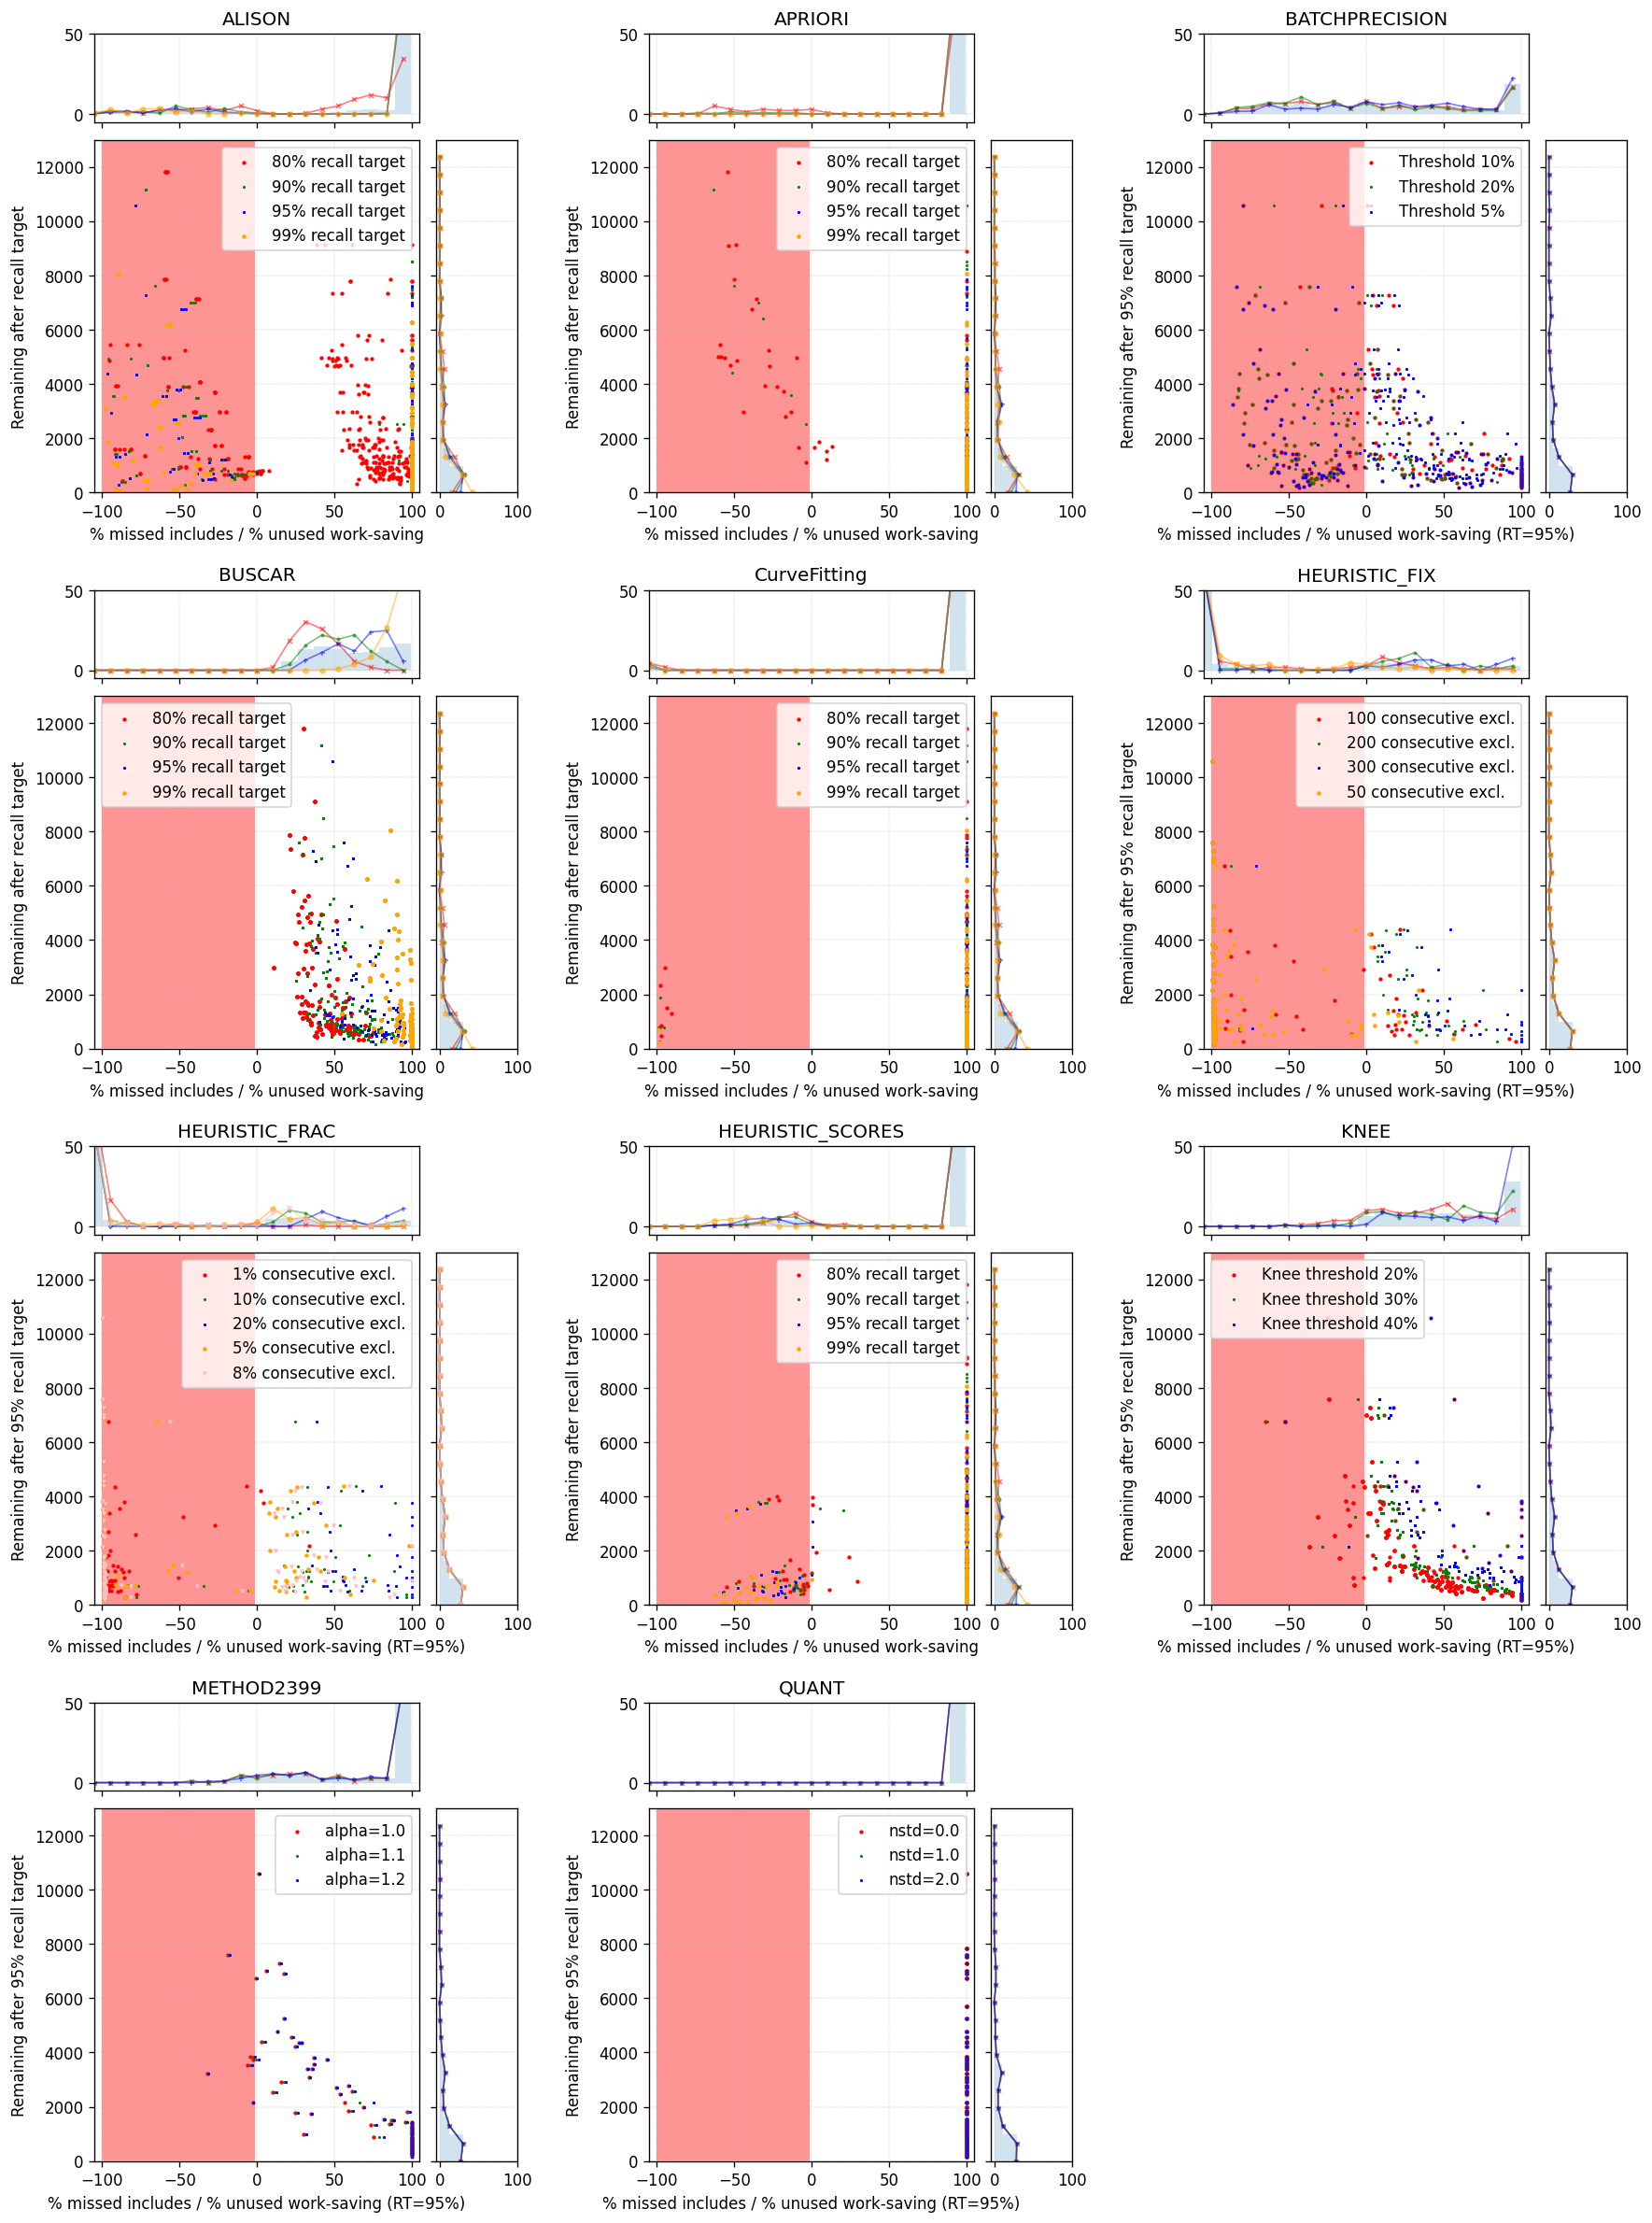

In [15]:
n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)
bins = 20
rt = 0.95

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

vred = True
hred = not True

#xval, xlab, xlim = ('work_saved', 'Work saved', (-0.1, 1.1))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#df_res['te'] = df_res[f'too_early%@recall={rt}'].fillna(0) * -100
#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('te', '% stopped before target', (-5, 105))

#xval, xlab1, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% missed includes / % unused work-saving (RT={rt:.0%})', '% missed includes / % unused work-saving',  (-105, 105)) # 400
#yval, ylab1, ylab2, ylim = (lambda x: 'n_total', 'Number of records', 'Number of records', (0, 13000))

xval, xlab1, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% missed includes / % unused work-saving (RT={rt:.0%})', '% missed includes / % unused work-saving',  (-105, 105)) # 400
yval, ylab1, ylab2, ylim = (lambda x: f'unseen@recall={x}', f'Remaining after {rt:.0%} recall target', 'Remaining after recall target', (0, 13000))


#xval, xlab1, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% before/after {rt:.0%} recall target', '% before/after recall target',  (-105, 105))
#yval, ylab1, ylab2, ylim = (lambda x: f'missed_%@recall={x}', f'% missed includes (RT={rt:.0%})', '% missed includes',  (-5, 105))

#xval, xlab, xlim = (f'missed%@recall={rt}', 'Missed', (-1.1, 0.1))
#yval, ylab, ylim = (f'too_late_{late_ref}%@recall={rt}', 'Overshoot', (-0.1, 5))

xys = []
hists_x, hists_y = {}, {}
for meth in sorted(df_res['method'].unique()):
    print(meth)
    mask = df_res['method'] == meth
    df_meth = df_res[mask]

    xlab, ylab = xlab1, ylab1
    xval_, yval_ = lambda x: xval(rt), lambda x: yval(rt)
    if meth in ['BUSCAR', 'ALISON', 'APRIORI', 'HEURISTIC_SCORES', 'CurveFitting']:
        group_col, groups = 'method-recall_target', {float(v_): f'{v_:.0%} recall target' for v_ in sorted(df_meth['method-recall_target'].unique())}
        xlab, ylab = xlab2, ylab2
        xval_, yval_ = lambda x: xval(x), lambda x: yval(x)
    elif meth == 'BATCHPRECISION':
        group_col, groups = 'method-threshold', {float(v_): f'Threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold'].unique())}
    elif meth == 'HEURISTIC_FIX':
        group_col, groups = 'method-num_to_stop', {int(v_): f'{v_:,.0f} consecutive excl.' for v_ in sorted(df_meth['method-num_to_stop'].unique())}
    elif meth == 'HEURISTIC_FRAC':
        group_col, groups = 'method-fraction', {float(v_): f'{v_:.0%} consecutive excl.' for v_ in sorted(df_meth['method-fraction'].unique())}
    elif meth == 'KNEE':
        group_col, groups = 'method-threshold_peak', {float(v_): f'Knee threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold_peak'].unique())}
    elif meth == 'METHOD2399':
        group_col, groups = 'method-alpha', {float(v_): f'alpha={v_:.1f}' for v_ in sorted(df_meth['method-alpha'].unique())}
    elif meth == 'QUANT':
        group_col, groups = 'method-nstd', {float(v_): f'nstd={v_:.1f}' for v_ in sorted(df_meth['method-nstd'].unique())}

    for vi, (g, v) in enumerate(groups.items()):
        xy = (
            df_meth[df_meth[group_col] == g]
            .rename(columns={xval_(g): 'x', yval_(g): 'y'})
            [['x', 'y']]
            .assign(
                xlabel=xlab,
                ylabel=ylab,
                method=meth,
                glabel=v,
                gval=g,
            )
        )

        xys.append(xy)

df_xy = pd.concat(xys)
print(df_xy.shape)

for mi, (meth, df_meth) in enumerate(df_xy.groupby('method')):
    print(meth, df_meth.shape)
    ax = axes[int(mi/n_cols)][mi%n_cols]

    #ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])

    if vred:
        ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
    if hred:
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)

    histx, edgex = np.histogram(df_meth['x'], bins=bins, range=xlim)
    histy, edgey = np.histogram(df_meth['y'], bins=bins, range=ylim)
    hists_x[meth] = histx
    hists_y[meth] = histy
  
    ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
    ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
    
    for vi, (glabel, df_grp) in enumerate(df_meth.groupby('glabel')):
        ax.scatter(df_grp['x'], df_grp['y'], s=3, c=colours[vi], marker=markers[vi], label=glabel)
        
        histx, edgex = np.histogram(df_grp['x'], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_grp['y'], bins=bins, range=ylim)
        ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
    
    #ax_histy.set_xscale('log')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.legend()

    ax.set_title(meth)
    ax.set_xlabel(df_meth.iloc[0]['xlabel'])
    ax.set_ylabel(df_meth.iloc[0]['ylabel'])
    ax.grid(lw=0.2, ls='--')
    ax_histx.grid(lw=0.2, ls='--')
    ax_histy.grid(lw=0.2, ls='--')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax_histx.set_xlim(xlim)
    ax_histx.set_ylim(-5, 50)
    ax_histy.set_xlim(-5, 100)
    ax_histy.set_ylim(ylim)

#fig.delaxes(axes[3][1])
fig.delaxes(axes[3][2])

    
fig.tight_layout()
#fig.show()
#fig.savefig('../data/plots/scatter3.png')

In [ ]:
udf_ = pd.DataFrame(hists_x | {xlab: edgex[:-1].astype(int)})
print(df_.to_latex(index=False))
df_.style.background_gradient(cmap='Blues', axis=0)

In [ ]:
df_ = pd.DataFrame(hists_y | {ylab: edgey[:-1].astype(int)})
print(df_.to_latex(index=False))
df_.style.background_gradient(cmap='Blues', axis=0)

# Previous figure versions

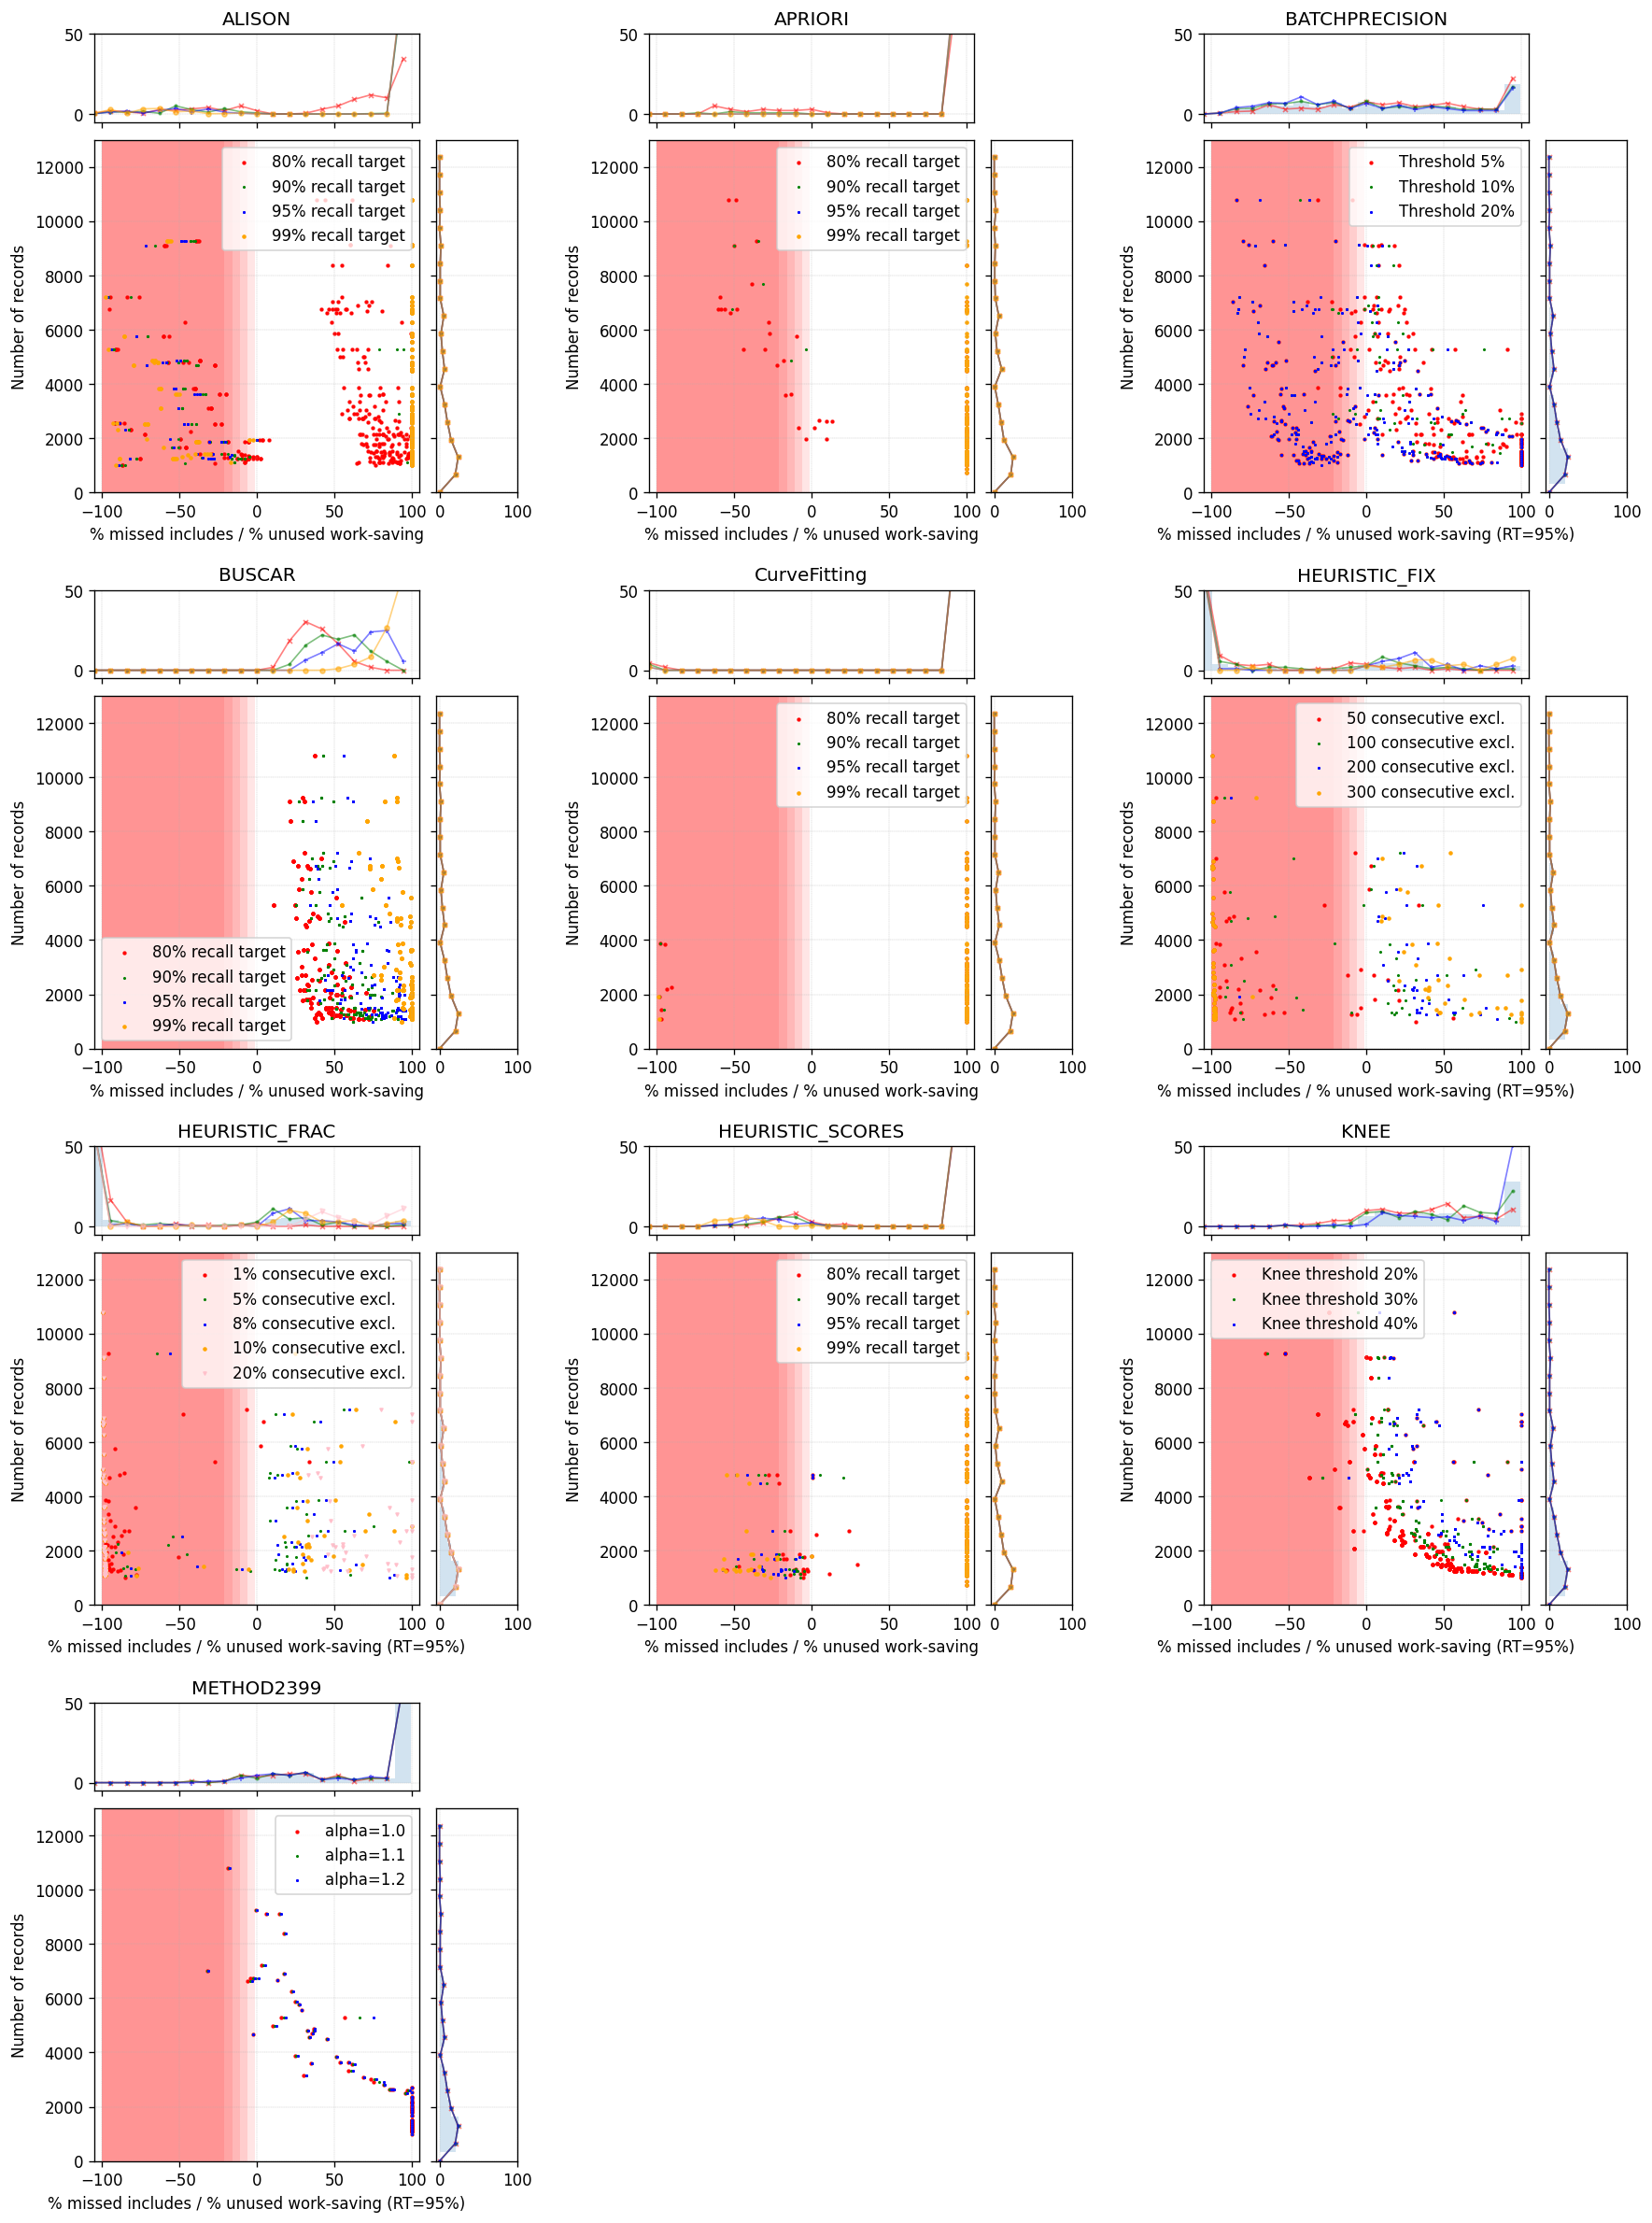

In [74]:
hists_y = {}
hists_x = {}

rt = 0.95  # recall target
bins = 20
late_ref = ['left', 'right'][1]

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

#xval, xlab, xlim = ('work_saved', 'Work saved', (-0.1, 1.1))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#df_res['te'] = df_res[f'too_early%@recall={rt}'].fillna(0) * -100
#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('te', '% stopped before target', (-5, 105))

xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% missed includes / % unused work-saving (RT={rt:.0%})', '% missed includes / % unused work-saving',  (-105, 105)) # 400
yval, ylab, ylab2, ylim = (lambda x: 'n_total', 'Number of records', 'Number of records', (0, 13000))

#xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% before/after {rt:.0%} recall target', '% before/after recall target',  (-105, 105))
#yval, ylab, ylab2, ylim = (lambda x: f'missed_%@recall={x}', f'% missed includes (RT={rt:.0%})', '% missed includes',  (-5, 105))

#xval, xlab, xlim = (f'missed%@recall={rt}', 'Missed', (-1.1, 0.1))
#yval, ylab, ylim = (f'too_late_{late_ref}%@recall={rt}', 'Overshoot', (-0.1, 5))

vred = False
hred = True

for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]

   # ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])

    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        group_col = 'method-recall_target'
        group_lab = lambda v_: f'{v_:.0%} recall target'
    elif meth == 'BATCHPRECISION':
        group_col = 'method-threshold'
        group_lab = lambda v_: f'Threshold {v_:.0%}'
    elif meth == 'HEURISTIC_FIX':
        group_col = 'method-num_to_stop'
        group_lab = lambda v_: f'{v_:,.0f} consecutive excl.'
    elif meth == 'HEURISTIC_FRAC':
        group_col = 'method-fraction'
        group_lab = lambda v_: f'{v_:.0%} consecutive excl.'
    elif meth == 'KNEE':
        group_col = 'method-threshold_peak'
        group_lab = lambda v_: f'Knee threshold {v_:.0%}'
    elif meth == 'METHOD2399':
        group_col = 'method-alpha'
        group_lab = lambda v_: f'alpha={v_:.1f}'
    else:
        group_col = None

    if vred:
        ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
    if hred:
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)

    if len(recall_targets) <= 1:
        histx, edgex = np.histogram(df_meth[xval(rt)], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_meth[yval(rt)], bins=bins, range=ylim)
        hists_x[meth] = histx
        hists_y[meth] = histy
      
        ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
        ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
    
    if group_col is None:
        df_meth.plot.scatter(x=xval, y=yval, ax=ax, s=1)
    else:
        values = sorted(df_meth[group_col].unique())
        for vi, v in enumerate(values):
            xy = df_meth[df_meth[group_col] == v].rename(columns={xval(v if len(recall_targets) > 1 else rt): 'x', yval(v if len(recall_targets) > 1 else rt): 'y'})[['x', 'y']]
            ax.scatter(xy['x'], xy['y'], s=3, c=colours[vi], marker=markers[vi], label=group_lab(v))

            histx, edgex = np.histogram(df_meth[df_meth[group_col] == v][xval(v if len(recall_targets) > 1 else rt)], bins=bins, range=xlim)
            histy, edgey = np.histogram(df_meth[df_meth[group_col] == v][yval(v if len(recall_targets) > 1 else rt)], bins=bins, range=ylim)
            ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
            ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        
           # xhist = np.linspace(xlim[0], xlim[1], bins)
           # xv = df_meth[df_meth[group_col] == v][xval]
           # gx = gaussian_kde(xv)(xhist) if np.var(xv) > 0 else np.ones_like(xhist) * xv.mean()
           # ax_histx.plot(xhist, gx / (gx + 1e-6).sum(), alpha=0.5, c=colours[vi], marker=markers[vi])
           # yhist = np.linspace(ylim[0], ylim[1], bins)
           # yv = df_meth[df_meth[group_col] == v][yval]
           # gy = gaussian_kde(yv)(yhist) if np.var(yv) > 0 else np.ones_like(yhist) * yv.mean()
           # ax_histy.plot(gy / (gy + 1e-6).sum(), yhist, alpha=0.5, c=colours[vi], marker=markers[vi])
        ax.legend()
    #ax_histy.set_xscale('log')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    
    ax.set_title(meth)
    ax.set_xlabel(xlab if len(recall_targets) <= 1 else xlab2)
    ax.set_ylabel(ylab if len(recall_targets) <= 1 else ylab2)
    ax.grid(lw=0.2, ls='--')
    ax_histx.grid(lw=0.2, ls='--')
    ax_histy.grid(lw=0.2, ls='--')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax_histx.set_xlim(xlim)
    ax_histx.set_ylim(-5, 50)
    ax_histy.set_xlim(-5, 100)
    ax_histy.set_ylim(ylim)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()
#fig.savefig('../data/plots/scatter.pdf')

In [105]:
fig.savefig('../data/plots/scatter.pdf')

In [49]:
pd.DataFrame(hists_y | {'Recall': edgey[:-1]}).style.background_gradient(cmap='Blues', axis=0)

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,CurveFitting,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_SCORES,KNEE,METHOD2399,Recall
0,0,0,0,0,0,0,0,0,0,0,-0.100000
1,4,0,0,0,3,266,333,0,0,0,-0.040000
2,37,0,25,0,12,24,34,0,12,0,0.020000
3,44,0,37,0,0,4,7,0,0,0,0.080000
4,52,1,35,0,0,6,5,4,0,0,0.140000
5,38,2,31,0,0,4,2,0,0,0,0.200000
6,18,2,37,0,0,0,0,5,0,0,0.260000
7,27,4,37,0,0,1,2,5,0,0,0.320000
8,17,7,15,0,0,0,0,6,0,0,0.380000
9,3,3,21,0,0,0,0,1,0,0,0.440000


In [48]:
pd.DataFrame(hists_x | {'Work saved': edgex[:-1]}).style.background_gradient(cmap='Blues', axis=0)

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,CurveFitting,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_SCORES,KNEE,METHOD2399,Work saved
0,137,1,105,0,15,303,379,4,12,0,-105.000000
1,105,18,136,0,0,2,4,18,0,0,-74.750000
2,65,10,63,0,0,2,1,55,0,0,-44.500000
3,29,10,178,112,0,23,20,36,112,33,-14.250000
4,228,56,189,528,48,67,69,49,416,53,16.000000
5,284,114,167,460,80,32,39,81,506,82,46.250000
6,298,112,85,252,87,6,19,81,214,70,76.500000
7,275,92,41,160,83,1,9,96,42,59,106.750000
8,72,21,13,76,24,0,3,16,0,18,137.000000
9,12,16,3,32,8,0,1,9,6,6,167.250000


In [29]:
df_res[(df_res['method'] == 'BUSCAR') & (df_res['stop_recall'] < 0.9)]

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-expected_includes,method-expected_remaining,method-predicted_recall,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-fraction,seen@recall=0.8,unseen@recall=0.8,seen_incl@recall=0.8,too_late@recall=0.8,too_late%@recall=0.8,too_early@recall=0.8,too_early%@recall=0.8,missed@recall=0.8,missed%@recall=0.8,seen@recall=0.85,unseen@recall=0.85,seen_incl@recall=0.85,too_late@recall=0.85,too_late%@recall=0.85,too_early@recall=0.85,too_early%@recall=0.85,missed@recall=0.85,missed%@recall=0.85,seen@recall=0.9,unseen@recall=0.9,seen_incl@recall=0.9,too_late@recall=0.9,too_late%@recall=0.9,too_early@recall=0.9,too_early%@recall=0.9,missed@recall=0.9,missed%@recall=0.9,seen@recall=0.95,unseen@recall=0.95,seen_incl@recall=0.95,too_late@recall=0.95,too_late%@recall=0.95,too_early@recall=0.95,too_early%@recall=0.95,missed@recall=0.95,missed%@recall=0.95,seen@recall=0.99,unseen@recall=0.99,seen_incl@recall=0.99,too_late@recall=0.99,too_late%@recall=0.99,too_early@recall=0.99,too_early%@recall=0.99,missed@recall=0.99,missed%@recall=0.99,seen@recall=1.0,unseen@recall=1.0,seen_incl@recall=1.0,too_late@recall=1.0,too_late%@recall=1.0,too_early@recall=1.0,too_early%@recall=1.0,missed@recall=1.0,missed%@recall=1.0,stop_recall,work_saved,incl_missed,x
7491,generic-paired-ris-NICE Ian Saunders,1,generic-paired-ris-NICE Ian Saunders-0-500-1-best,174,5288,2625,2663,1957,1689,0,15,BUSCAR,True,BUSCAR-0cb824deffd1fac67da3a1cde0981477077be802,BUSCAR,True,0.006835,0.8,NaN,NaN,10.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2310,2978,1569,315,0.136364,0,0.0,0,0.0,2565,2723,1671,60,0.023392,0,0.0,0,0.0,2775,2513,1762,0,0.0,150,-0.054054,73,-0.037302,3120,2168,1862,0,0.0,495,-0.158654,173,-0.088401,3975,1313,1938,0,0.0,1350,-0.339623,249,-0.127236,4995,293,1957,0,0.0,2370,-0.474474,268,-0.136944,0.863056,0.503593,0.136944,-8.840061
7494,generic-paired-ris-NICE Ian Saunders,1,generic-paired-ris-NICE Ian Saunders-0-500-1-best,174,5288,2625,2663,1957,1689,0,15,BUSCAR,True,BUSCAR-65b0784c5421872b769f7899dfeeb10ef11bc59a,BUSCAR,True,0.006835,0.8,NaN,NaN,5.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2310,2978,1569,315,0.136364,0,0.0,0,0.0,2565,2723,1671,60,0.023392,0,0.0,0,0.0,2775,2513,1762,0,0.0,150,-0.054054,73,-0.037302,3120,2168,1862,0,0.0,495,-0.158654,173,-0.088401,3975,1313,1938,0,0.0,1350,-0.339623,249,-0.127236,4995,293,1957,0,0.0,2370,-0.474474,268,-0.136944,0.863056,0.503593,0.136944,-8.840061
7500,generic-paired-ris-NICE Ian Saunders,1,generic-paired-ris-NICE Ian Saunders-0-500-1-best,174,5288,2625,2663,1957,1689,0,15,BUSCAR,True,BUSCAR-acbe70bfb087950c3c4f7c4dd935df2accca0966,BUSCAR,True,0.006835,0.8,NaN,NaN,2.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2310,2978,1569,315,0.136364,0,0.0,0,0.0,2565,2723,1671,60,0.023392,0,0.0,0,0.0,2775,2513,1762,0,0.0,150,-0.054054,73,-0.037302,3120,2168,1862,0,0.0,495,-0.158654,173,-0.088401,3975,1313,1938,0,0.0,1350,-0.339623,249,-0.127236,4995,293,1957,0,0.0,2370,-0.474474,268,-0.136944,0.863056,0.503593,0.136944,-8.840061
7504,generic-paired-ris-NICE Ian Saunders,1,generic-paired-ris-NICE Ian Saunders-0-500-1-best,174,5288,2625,2663,1957,1689,0,15,BUSCAR,True,BUSCAR-d0cb3885da47cdd7116e42a25e1ffb507e22c715,BUSCAR,True,0.006835,0.8,NaN,NaN,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

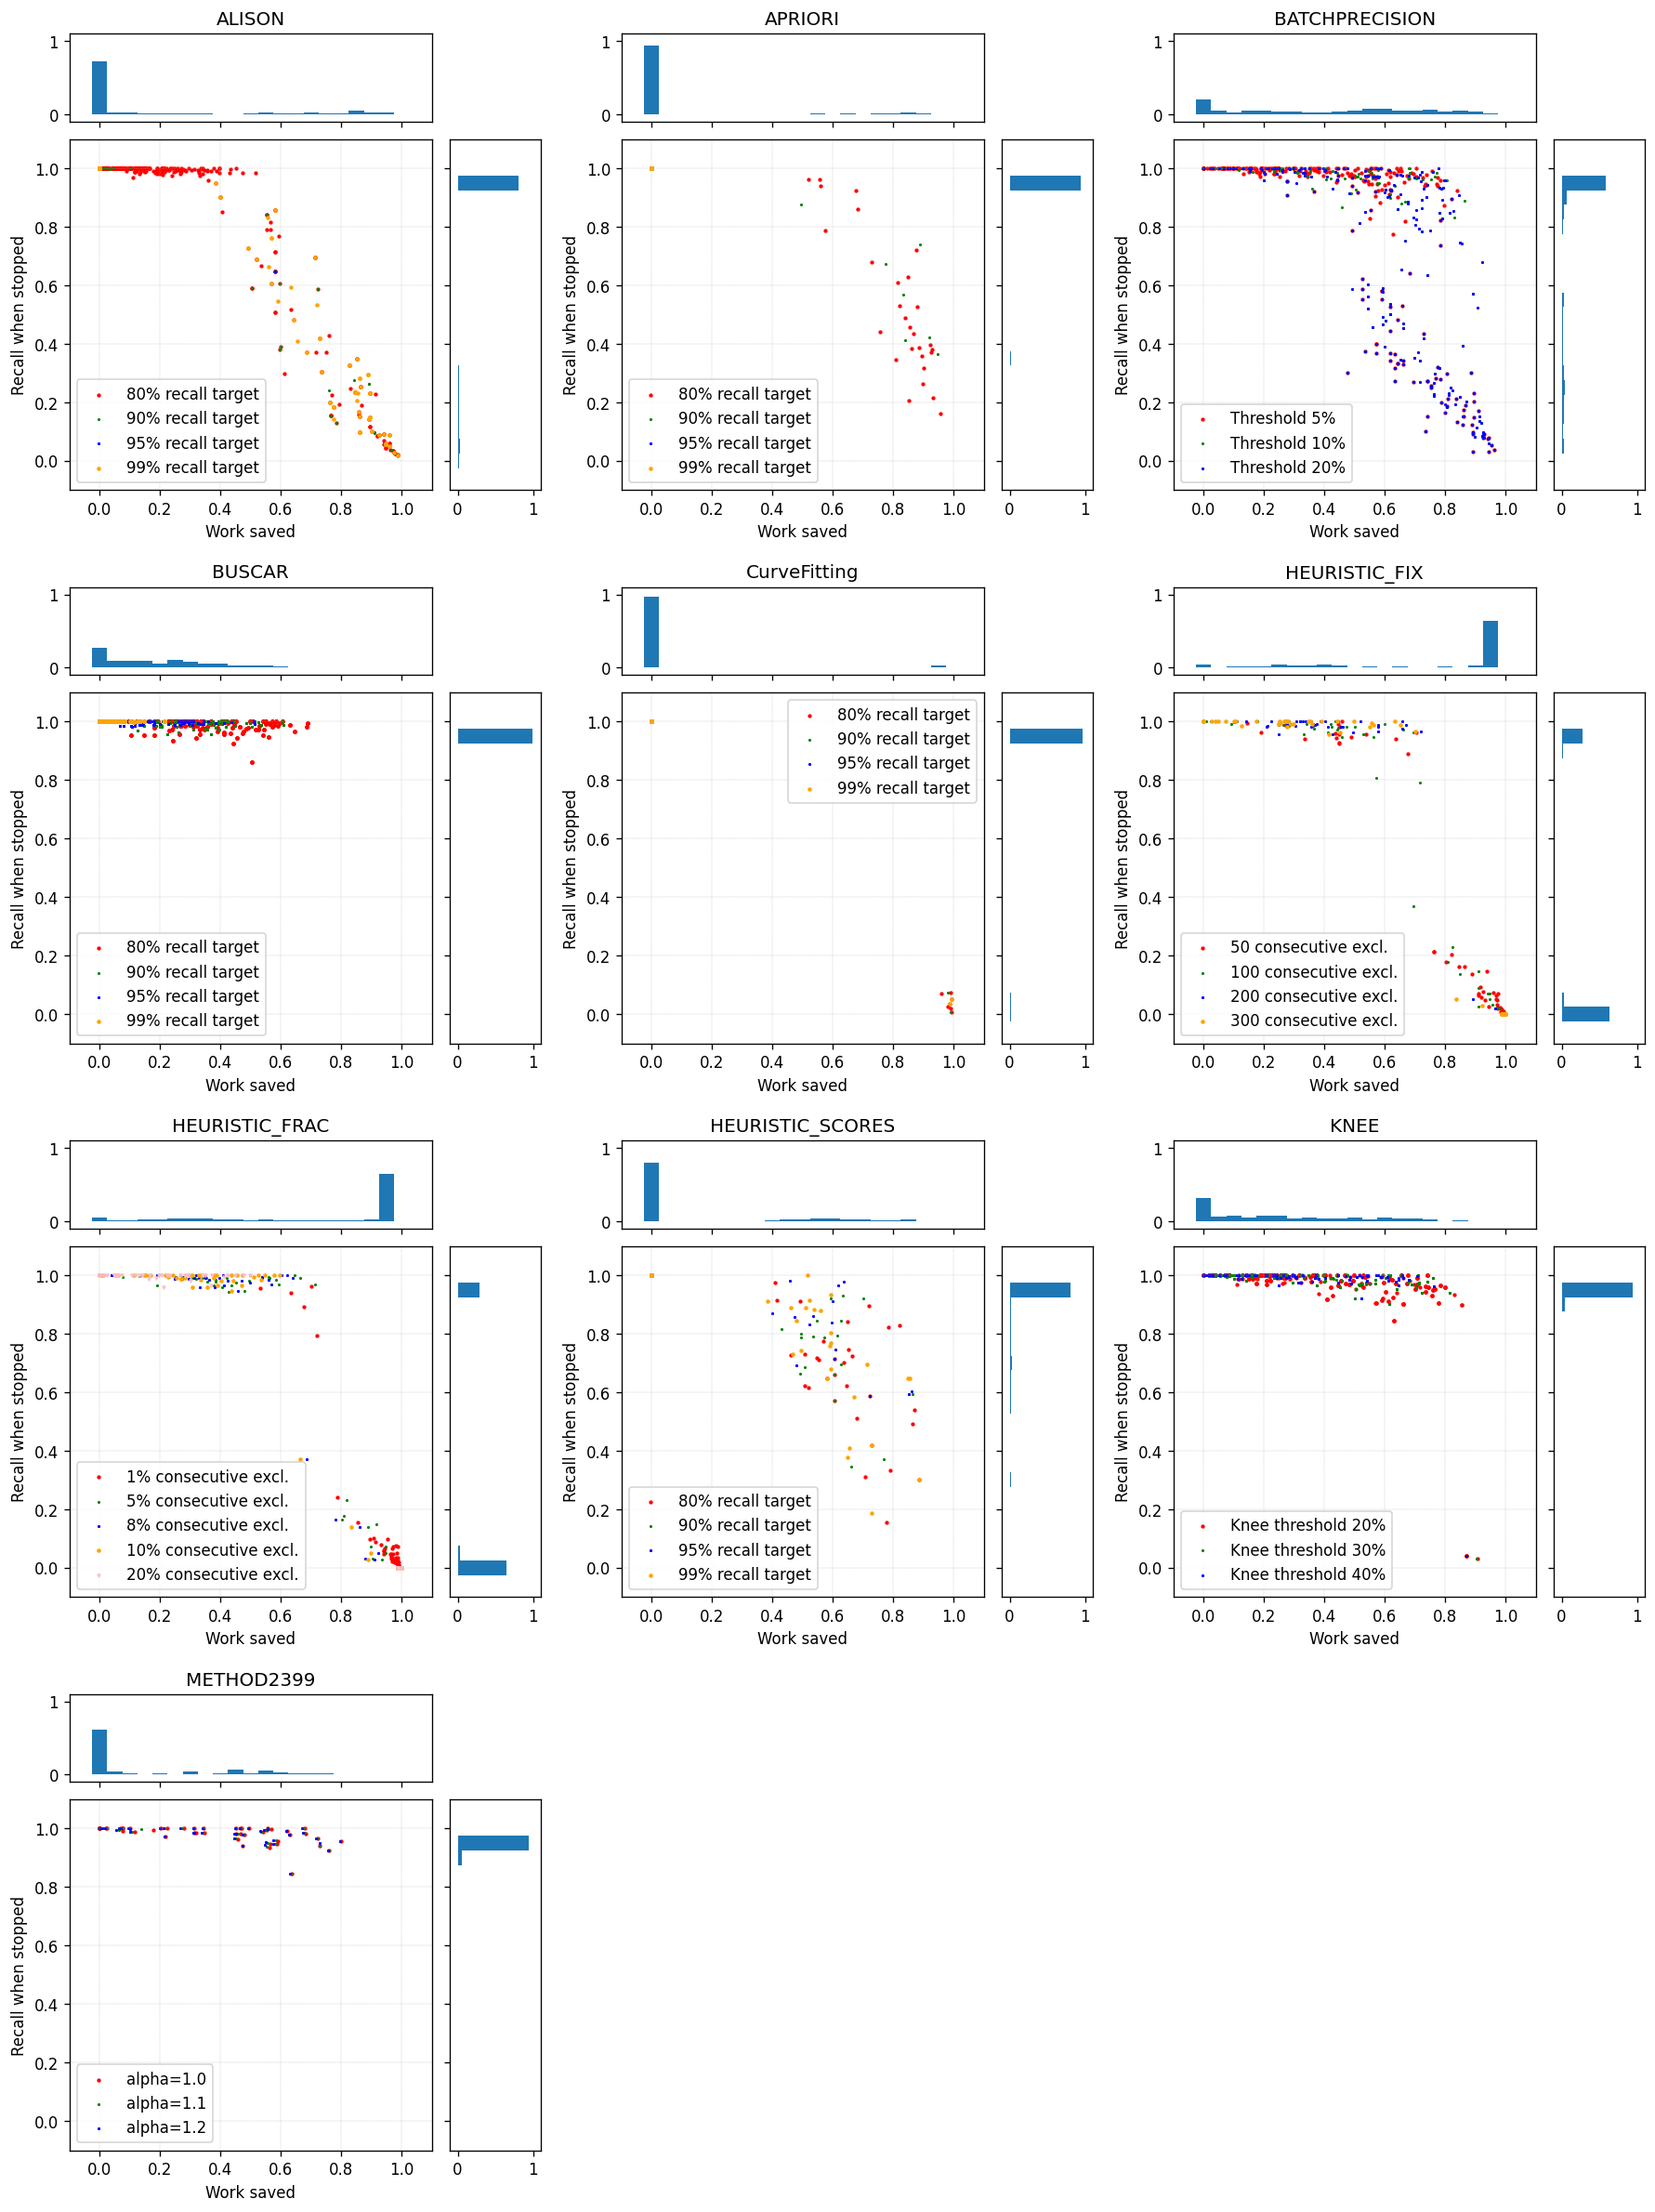

In [283]:
hists_y = {}
hists_x = {}

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

xval = 'work_saved'
xlab = 'Work saved'
for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]
    
    ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])


    ax.set_title(meth)
    ax.set_ylabel('Recall when stopped')
    ax.set_xlabel(xlab)
    ax.grid(lw=0.2, ls='--')
    
    bins = 20
    binwidth = 1 / bins
    bins = np.arange(0, 1 + binwidth, binwidth)
    
    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        for rti, rt in enumerate(recall_targets):
            df_meth[df_meth['method-recall_target'] == rt].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[rti], marker=markers[rti], label=f'{rt:.0%} recall target')
        ax.legend()
    elif meth == 'BATCHPRECISION':
        thresholds = sorted(df_meth['method-threshold'].unique())
        for thi, th in enumerate(thresholds):
            df_meth[df_meth['method-threshold'] == th].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[thi], marker=markers[thi], label=f'Threshold {th:.0%}')
        ax.legend()
    elif meth == 'HEURISTIC_FIX':
        values = sorted(df_meth['method-num_to_stop'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-num_to_stop'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:,.0f} consecutive excl.')
    elif meth == 'HEURISTIC_FRAC':
        values = sorted(df_meth['method-fraction'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-fraction'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:.0%} consecutive excl.')
        ax.legend()
    elif meth == 'KNEE':
        values = sorted(df_meth['method-threshold_peak'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-threshold_peak'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'Knee threshold {v:.0%}')
        ax.legend()
    elif meth == 'METHOD2399':
        values = sorted(df_meth['method-alpha'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-alpha'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'alpha={v:.1f}')
        ax.legend()
    else:
        df_meth.plot.scatter(x=xval, y='stop_recall', ax=ax, s=1)

    histx, _ = np.histogram(df_meth[xval], bins=bins)
    histy, _ = np.histogram(df_meth['stop_recall'], bins=bins)
    ax_histx.bar(bins[:-1], height=histx / histx.sum(), width=binwidth)
    ax_histy.barh(y=bins[:-1], width=histy / histy.sum(), height=binwidth)
    
    hists_x[meth] = histx
    hists_y[meth] = histy

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)

    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-0.1, 1.1)
    ax_histx.set_xlim(-0.1, 1.1)
    ax_histx.set_ylim(-0.1, 1.1)
    ax_histy.set_xlim(-0.1, 1.1)
    ax_histy.set_ylim(-0.1, 1.1)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()

<Axes: xlabel='work_saved', ylabel='stop_recall'>

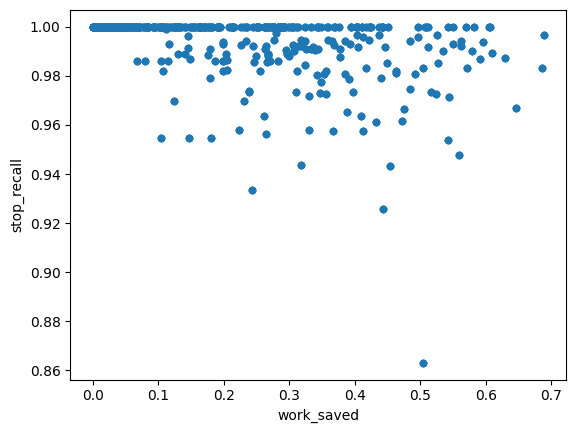

In [190]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='work_saved', y='stop_recall')

<Axes: xlabel='method-recall_target', ylabel='stop_recall'>

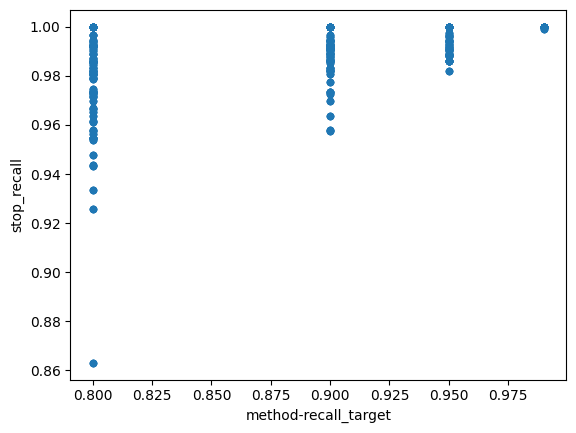

In [191]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='method-recall_target', y='stop_recall')

TypeError: 'Axes' object is not callable

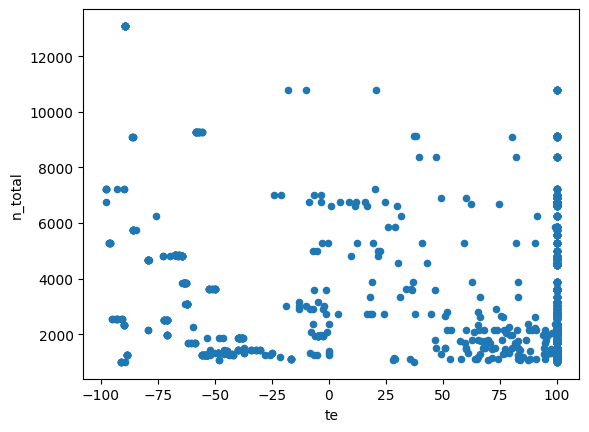

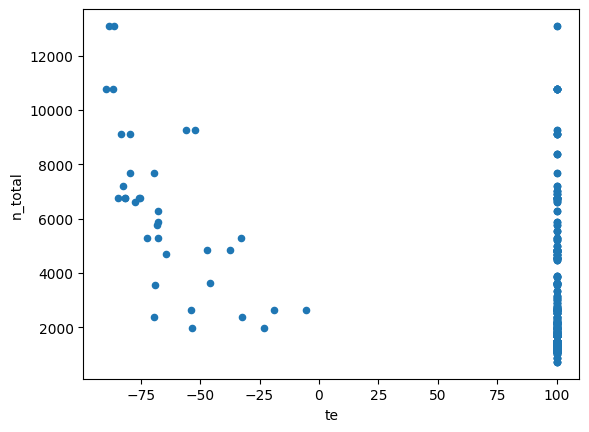

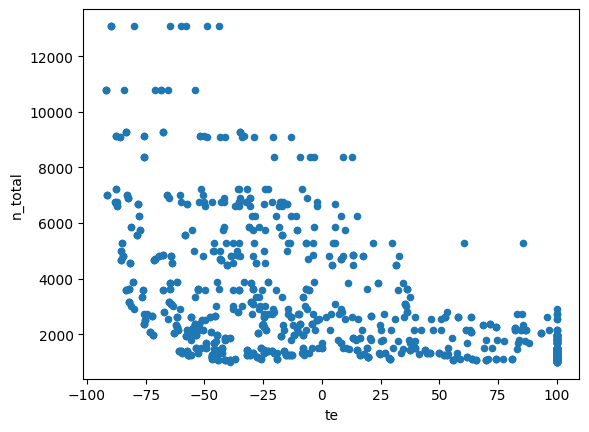

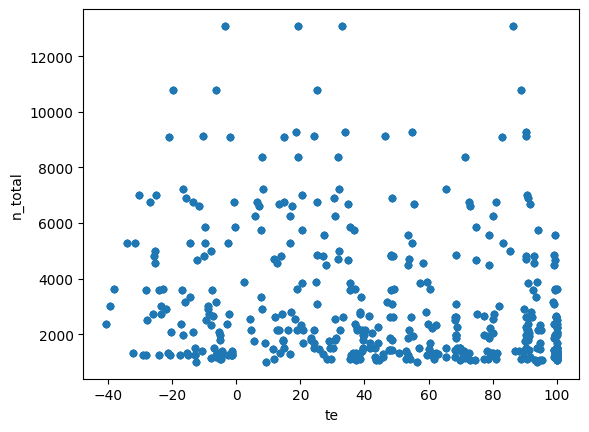

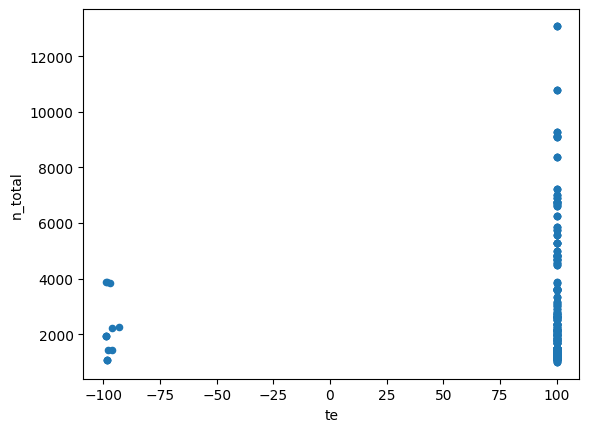

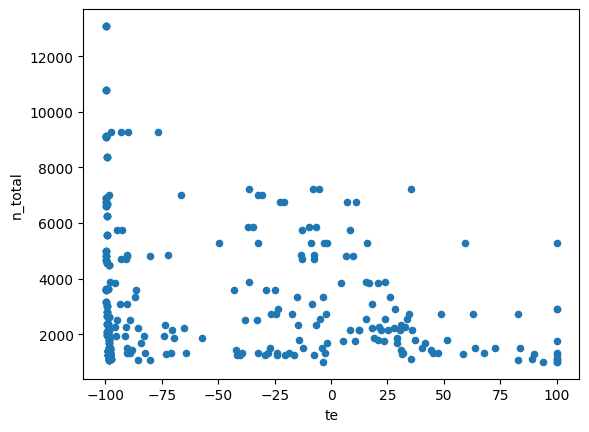

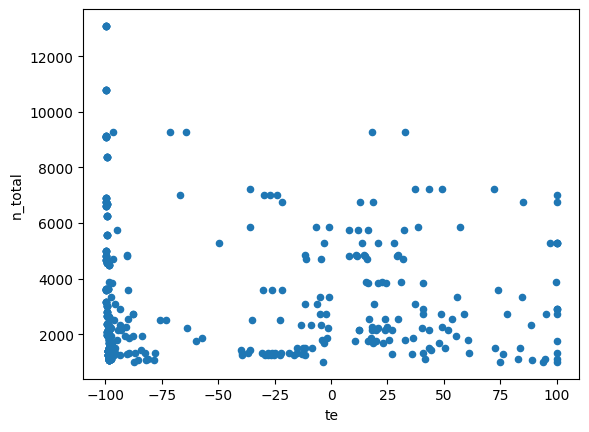

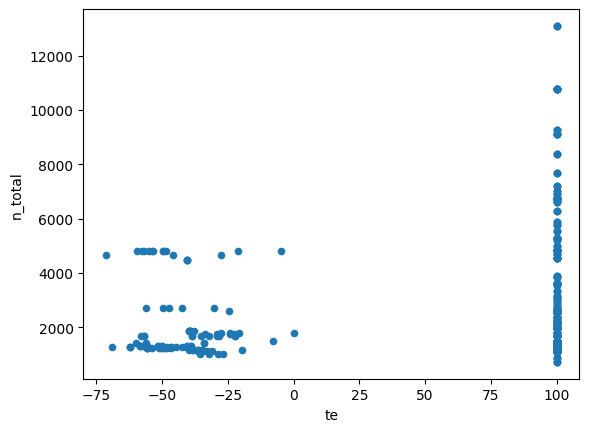

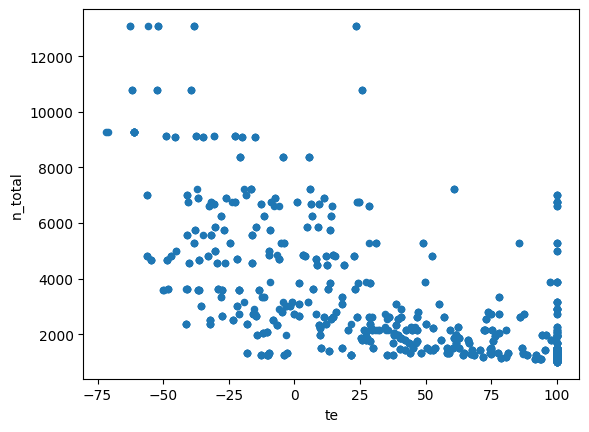

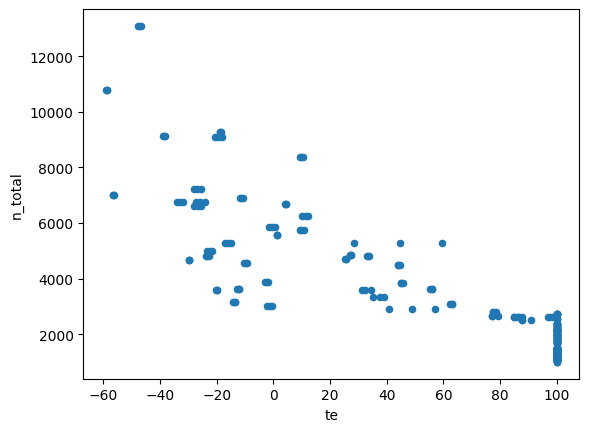

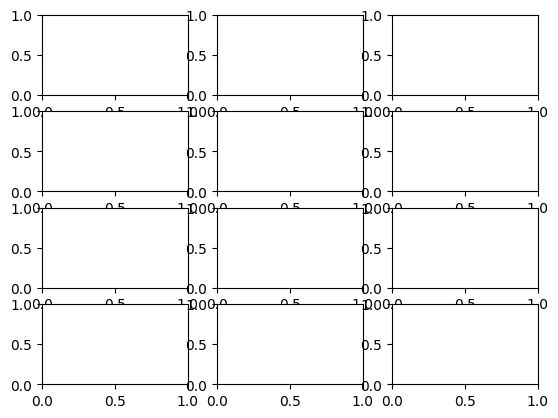

In [25]:
plots = df_res.groupby('method').plot.scatter(x='te', y='n_total')
fig, axes = plt.subplots(4, 3)
for i, (m, p) in enumerate(plots.items()):
    axes[i//3][i%3].axes(p)
    p.set_title(m)


In [194]:
df.head()

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-bias,method-confidence_level,method-expected_includes,method-expected_remaining,method-predicted_recall,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-n_windows,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-fraction
0,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,BUSCAR,False,BUSCAR-d0cb3885da47cdd7116e42a25e1ffb507e22c715,BUSCAR,False,0.996713,0.8,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,BUSCAR,False,BUSCAR-acbe70bfb087950c3c4f7c4dd935df2accca0966,BUSCAR,False,0.996713,0.8,2.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,BUSCAR,False,BUSCAR-65b0784c5421872b769f7899dfeeb10ef11bc59a,BUSCAR,False,0.996713,0.8,5.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,BUSCAR,False,BUSCAR-0cb824deffd1fac67da3a1cde0981477077be802,BUSCAR,False,0.996713,0.8,10.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,BUSCAR,False,BUSCAR-bb5e08fb12b0f17b6a29d0c5e85c4b5c64695b14,BUSCAR,False,0.996713,0.9,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

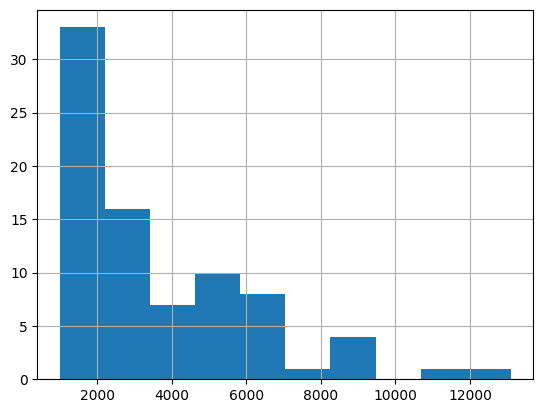

In [196]:
df.groupby('dataset').first()['n_total'].hist()

In [282]:
df_meth

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-expected_includes,method-expected_remaining,method-predicted_recall,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-fraction,seen@recall=0.8,unseen@recall=0.8,seen_incl@recall=0.8,too_late@recall=0.8,too_early@recall=0.8,missed@recall=0.8,missed%@recall=0.8,too_late%@recall=0.8,too_early%@recall=0.8,seen@recall=0.85,unseen@recall=0.85,seen_incl@recall=0.85,too_late@recall=0.85,too_early@recall=0.85,missed@recall=0.85,missed%@recall=0.85,too_late%@recall=0.85,too_early%@recall=0.85,seen@recall=0.9,unseen@recall=0.9,seen_incl@recall=0.9,too_late@recall=0.9,too_early@recall=0.9,missed@recall=0.9,missed%@recall=0.9,too_late%@recall=0.9,too_early%@recall=0.9,seen@recall=0.95,unseen@recall=0.95,seen_incl@recall=0.95,too_late@recall=0.95,too_early@recall=0.95,missed@recall=0.95,missed%@recall=0.95,too_late%@recall=0.95,too_early%@recall=0.95,seen@recall=0.99,unseen@recall=0.99,seen_incl@recall=0.99,too_late@recall=0.99,too_early@recall=0.99,missed@recall=0.99,missed%@recall=0.99,too_late%@recall=0.99,too_early%@recall=0.99,seen@recall=1.0,unseen@recall=1.0,seen_incl@recall=1.0,too_late@recall=1.0,too_early@recall=1.0,missed@recall=1.0,missed%@recall=1.0,too_late%@recall=1.0,too_early%@recall=1.0,stop_recall,work_saved,incl_missed,x
8,clef-CD005139,2,clef-CD005139-0-500-2-best,304,4564,4564,0,105,105,0,15,ALISON,False,ALISON-417e55e2a26d7f24cad8370396678f36024acb8f,ALISON,False,NaN,0.99,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,3604,84,3604,0,21,-0.200000,3.754167,0.0,1020,3544,90,3544,0,15,-0.142857,3.474510,0.0,1245,3319,95,3319,0,10,-0.095238,2.665863,0.0,1470,3094,100,3094,0,5,-0.047619,2.104762,0.0,2790,1774,104,1774,0,1,-0.009524,0.635842,0.0,3330,1234,105,1234,0,0,0.0,0.370571,0.0,1.0,0.000000,0.0,2.104762
9,clef-CD005139,2,clef-CD005139-0-500-2-best,221,4564,3330,1234,105,105,1,15,ALISON,True,ALISON-502d519a5da2e428cb4ae83cc327d8199a4e6e28,ALISON,True,NaN,0.80,NaN,NaN,NaN,0.80,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,3604,84,2370,0,21,-0.200000,2.468750,0.0,1020,3544,90,2310,0,15,-0.142857,2.264706,0.0,1245,3319,95,2085,0,10,-0.095238,1.674699,0.0,1470,3094,100,1860,0,5,-0.047619,1.265306,0.0,2790,1774,104,540,0,1,-0.009524,0.193548,0.0,3330,1234,105,0,0,0,0.0,0.000000,0.0,1.0,0.270377,0.0,1.265306
10,clef-CD005139,2,clef-CD005139-0-500-2-best,304,4564,4564,0,105,105,0,15,ALISON,False,ALISON-5f542022639c694d0c669ba3875bcea7f3fb8b3e,ALISON,False,NaN,0.99,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,3604,84,3604,0,21,-0.200000,3.754167,0.0,1020,3544,90,3544,0,15,-0.142857,3.474510,0.0,1245,3319,95,3319,0,10,-0.095238,2.665863,0.0,1470,3094,100,3094,0,5,-0.047619,2.104762,0.0,2790,1774,104,1774,0,1,-0.009524,0.635842,0.0,3330,1234,105,1234,0,0,0.0,0.370571,0.0,1.0,0.000000,0.0,2.104762
11,clef-CD005139,2,clef-CD005139-0-500-2-best,304,4564,4564,0,105,105,0,15,ALISON,False,ALISON-6bfe1978bea8ac323c29190eb7a2762af868a3c4,ALISON,False,NaN,0.90,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960,3604,84,3604,0,21,-0.200000,3.754167,0.0,1020,3544,90,3544,0,15,-0.142857,3.474510,0.0,1245,3319,95,3319,0,10,-0.095238,2.665863,0.0,1470,3094,100,3094,0,5,-0.047619,2.104762,0.0,2790,1774,104,1774,0,1,-0.009524,0.635842,0.0,3330,1234,105,1234